## A notebook for the Technical Validation part of the paper

## Import and install libraries

In [409]:
%pip install pandas seaborn matplotlib requests

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import requests
from io import StringIO

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Global settings

In [410]:
# set theme
sns.set_theme(rc={'figure.figsize': (12.7,6.27)})

# Set global font sizes using rcParams
plt.rcParams.update({
    "axes.titlesize": 27,    # Font size for plot titles
    "axes.labelsize": 15,    # Font size for x and y labels
    "xtick.labelsize": 12,   # Font size for x-axis tick labels
    "ytick.labelsize": 12  # Font size for y-axis tick labels
})

## (1) HRA growth over time

In [411]:
# import HRA growth
growth = pd.read_csv(
    "https://cdn.humanatlas.io/hra-dashboard-data/data/hra-growth.csv")
growth

,group,date,count,order
0,tissue providers,2020-02-10,1,1
1,tissue providers,2020-02-12,1,1
2,tissue providers,2020-05-18,1,1
3,tissue providers,2021-02-10,1,1
4,tissue providers,2021-03-16,2,1
...,...,...,...,...
110,SOPs,2023-10-18,1,10
111,SOPs,2023-12-11,1,10
112,SOPs,2023-12-13,1,10
113,SOPs,2024-06-12,6,10


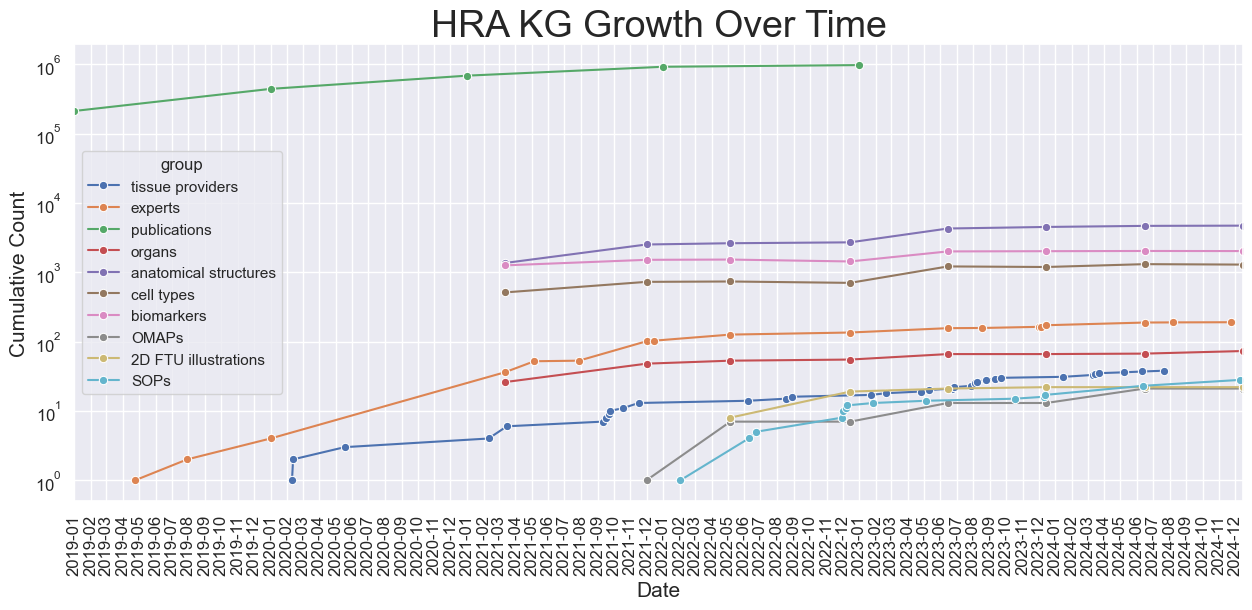

In [412]:
# vega-lite spec: https://cdn.humanatlas.io/hra-dashboard-data/data/hra-growth.vl.json

# Convert date to datetime
growth['date'] = pd.to_datetime(growth['date'])

# Calculate cumulative sum
growth['cumulative_count'] = growth.groupby("group")['count'].cumsum()

# Create the line plot
sns.lineplot(
    data=growth,
    x='date',
    y='cumulative_count',
    hue='group',
    marker='o'
)

# Customize the plot
plt.title('HRA KG Growth Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Count')

# Set monthly ticks
ax = plt.gca()  # get current axis
# set ticks to appear at start of each month
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))  # format as YYYY-MM

# Set y-axis to logarithmic scale
plt.yscale('log')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set the x-axis limits
filtered_data = growth.dropna()
plt.xlim(filtered_data["date"].min(), filtered_data["date"].max())

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

## (2) DOs per organ

In [413]:
# import DOs per organ
dos_per_organ = pd.read_csv(
    "https://cdn.humanatlas.io/hra-dashboard-data/data/digital-objects-per-organ.csv")
dos_per_organ

,organ,type,count
0,anatomical systems,ASCT+B Table,1
1,blood,CTAnn Crosswalks,3
2,blood pelvis,ASCT+B Table,1
3,blood vasculature,ASCT+B Table,1
4,blood vasculature,CTAnn Crosswalks,1
...,...,...,...
101,uterus,ASCT+B Table,1
102,uterus,CTAnn Crosswalks,1
103,uterus,3D Reference Organ,2
104,vascular system,CTAnn Crosswalks,1


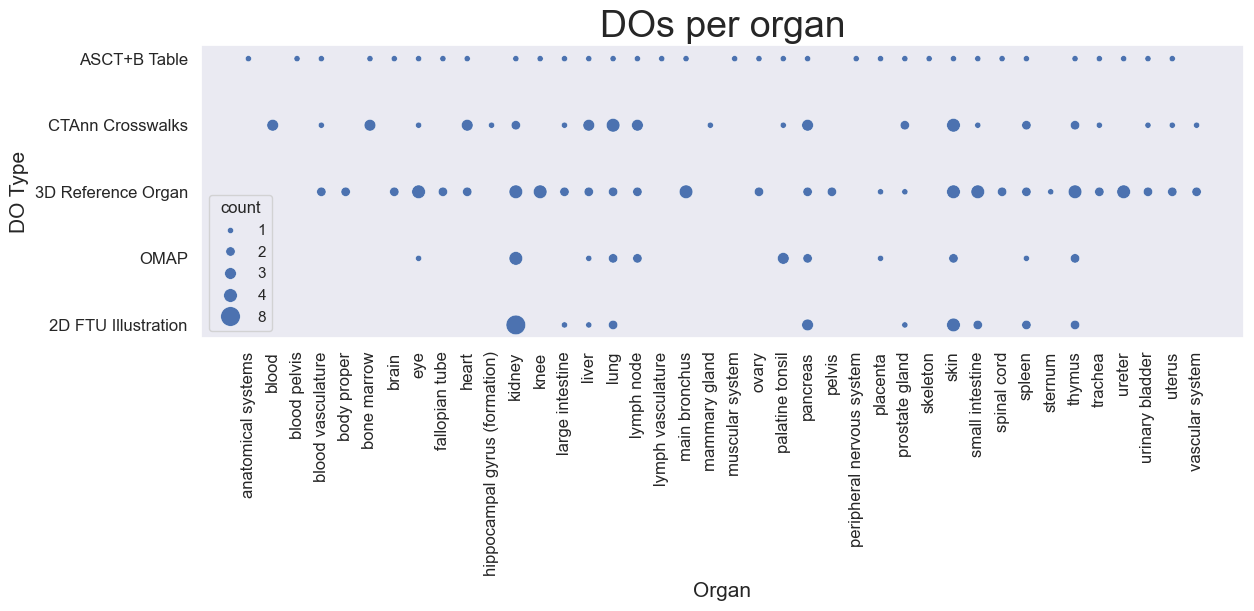

In [414]:
# vega-lite spec: https://cdn.humanatlas.io/hra-dashboard-data/data/digital-objects-per-organ.vl.json

dos_per_organ

color_map = sns.choose_colorbrewer_palette("YlGnBu", as_cmap=True)

# Create the line plot
sns.scatterplot(
    data=dos_per_organ,
   x="organ",
   y="type",
   size="count",
   sizes=(20, 200)
)

# Customize the plot
plt.title('DOs per organ')
plt.xlabel('Organ')
plt.ylabel('DO Type')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Remove the grid
plt.grid(False)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

## (3) Ontology terms added over time

In [415]:
# import ontoloogies extended over time
ontology_terms_added = pd.read_csv("https://cdn.humanatlas.io/hra-dashboard-data/data/ontology-terms-added.csv")
ontology_terms_added

,date,count,ontology
0,2023-01-01,50,CL
1,2023-02-15,14,CL
2,2023-03-21,11,CL
3,2023-04-20,11,CL
4,2023-05-22,5,CL
5,2023-06-22,7,CL
6,2023-07-20,0,CL
7,2023-08-24,6,CL
8,2023-09-21,2,CL
9,2023-10-19,5,CL


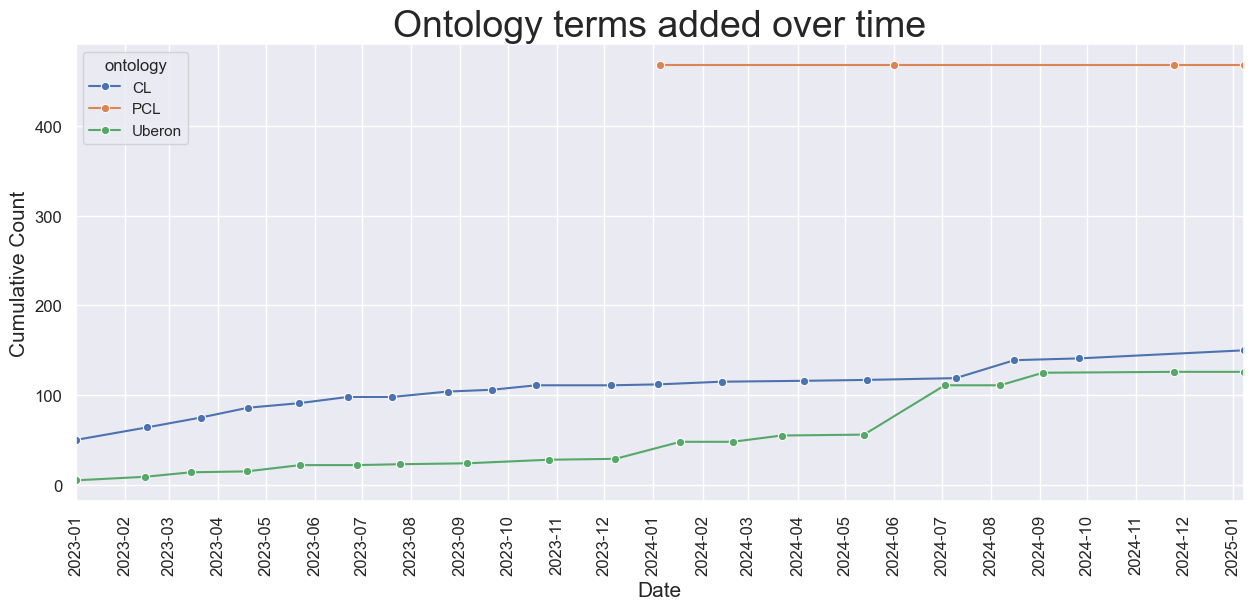

In [416]:
# vega-lite spec: https://cdn.humanatlas.io/hra-dashboard-data/data/ontology-terms-added.vl.json

# Convert date to datetime
ontology_terms_added['date'] = pd.to_datetime(ontology_terms_added['date'])

# Calculate cumulative sum
ontology_terms_added['cumulative_count'] = ontology_terms_added.groupby("ontology")[
    'count'].cumsum()

# Create the line plot
sns.lineplot(
    data=ontology_terms_added,
    x='date',
    y='cumulative_count',
    hue='ontology',
    marker='o'
)

# Customize the plot
plt.title('Ontology terms added over time')
plt.xlabel('Date')
plt.ylabel('Cumulative Count')

# Set monthly ticks
ax = plt.gca()  # get current axis
# set ticks to appear at start of each month
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))  # format as YYYY-MM

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set the x-axis limits
filtered_data = ontology_terms_added.dropna()
plt.xlim(filtered_data["date"].min(), filtered_data["date"].max())

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

## (4) Terms linked to ontologies over time

In [490]:
# GitHub repository details
repo_owner = 'hubmapconsortium'
repo_name = 'ccf-validation-tools'
folder_path = 'reports'
branch = 'master' 

# GitHub API URL to get files in the folder
url = f'https://api.github.com/repos/{repo_owner}/{
    repo_name}/contents/{folder_path}?ref={branch}'

# Fetch the file list from the repository
response = requests.get(url)
files = response.json()

# initlalize list of ds to hold TSV reports
list_df_terms = []
list_df_relationships = []

# Iterate over files and check for TSV files
for file in files:
    if file['name'].endswith('.tsv'):
        # URL for downloading the raw content of the file
        file_url = file['download_url']
        tsv_response = requests.get(file_url)

        # Check if the file is downloaded successfully
        if tsv_response.status_code == 200:
            tsv_data = tsv_response.text

            # Use StringIO to convert the text to a file-like object for pandas to read
            tsv_file = StringIO(tsv_data)

            # Read the TSV file into a DataFrame
            df = pd.read_csv(tsv_file, sep='\t')

            df['Date'] = file['name'].split('_')[len(file['name'].split('_'))-1].replace('.tsv', '')
            
            # put into list depending on file name (terms or relationships)
            if "terms" in file['name']:
              list_df_terms.append(df)
            elif "relationship" in file['name']:
              list_df_relationships.append(df)
        else:
            print(f"Failed to download {file['name']}")
            
print(f'Length of list_df_terms: {len(list_df_terms)}')
print(f'Length of list_df_relationships: {len(list_df_relationships)}')

Length of list_df_terms: 162
Length of df_relationships: 160


In [508]:
list_df_terms[6].columns

Index(['Table', 'AS_valid_term_number', 'AS_invalid_term_number',
       'AS_invalid_term_percent', 'CT_valid_term_number',
       'CT_invalid_term_number', 'CT_invalid_term_percent', 'Date'],
      dtype='object')

In [492]:
list_df_terms[151].columns

Index(['Table', 'AS_valid_term_number', 'AS_temp_term_number', 'AS_out_ub',
       'AS_invalid_term_number', 'AS_invalid_term_percent',
       'CT_valid_term_number', 'CT_temp_term_number', 'CT_out_ub',
       'CT_invalid_term_number', 'CT_invalid_term_percent',
       'invalid_terms_percent', 'Date'],
      dtype='object')

In [ ]:
keep = ['Table', 'Date',  'AS_valid_term_number', 'AS_invalid_term_number',
        'CT_valid_term_number', 'CT_invalid_term_number']

# merge 
merged_df = pd.merge(
    list_df_terms[6], list_df_terms[151], on=keep, how="outer")

merged_df = merged_df[keep]

merged_df

,Table,Date,AS_valid_term_number,AS_invalid_term_number,CT_valid_term_number,CT_invalid_term_number
0,Anatomical_Systems,20241113,81,0,0,0
1,Blood,20211116,1,0,28,4
2,Blood,20241113,1,0,29,0
3,Blood_vasculature,20241113,429,628,10,0
4,Bone-Marrow,20211116,1,0,44,11
5,Bone-Marrow,20241113,1,0,47,0
6,Brain,20211116,122,63,0,127
7,Brain,20241113,172,18,622,0
8,Eye,20211116,30,2,37,22
9,Eye,20241113,38,3,49,7


In [496]:
 list_df_terms[0]

,Table,invalid_term_number,invalid_term_percent,Date
0,Brain,190,61.29,20211028
1,Bone-Marrow_Blood,11,22.45,20211028
2,Heart,26,36.62,20211028
3,Kidney,23,18.55,20211028
4,Large_intestine,12,10.00,20211028
5,Lung,116,49.36,20211028
6,Skin,4,7.84,20211028
7,Lymph_node,45,42.06,20211028
8,Spleen,33,34.02,20211028
9,Thymus,17,24.64,20211028


In [497]:
 list_df_terms[1]

,Table,AS_invalid_term_number,AS_invalid_term_percent,CT_invalid_term_number,CT_invalid_term_percent,Date
0,Brain,63,20.32,127,40.97,20211029
1,Bone-Marrow_Blood,0,0.00,11,22.45,20211029
2,Heart,21,29.58,5,7.04,20211029
3,Kidney,7,5.65,16,12.90,20211029
4,Large_intestine,0,0.00,12,10.00,20211029
5,Lung,94,40.00,22,9.36,20211029
6,Skin,0,0.00,4,7.84,20211029
7,Lymph_node,2,1.87,43,40.19,20211029
8,Spleen,12,12.37,21,21.65,20211029
9,Thymus,0,0.00,17,24.64,20211029


In [498]:
# import AS and CT and B terms linked to ontologies over time:
# get data from https://github.com/hubmapconsortium/ccf-validation-tools/tree/master/reports
# Also: https://docs.google.com/spreadsheets/d/1ShCJ4EKU7W7nvTZutOwW24B9adR7j60iuGKCYkLVHzE/edit?gid=0#gid=0
linked_over_time = pd.read_csv(
    "https://raw.githubusercontent.com/hubmapconsortium/ccf-validation-tools/refs/heads/master/reports/report_terms_20250122.tsv", sep="\t")
linked_over_time

,Table,AS_valid_term_number,AS_temp_term_number,AS_out_ub,AS_invalid_term_number,AS_invalid_term_percent,CT_valid_term_number,CT_temp_term_number,CT_out_ub,CT_invalid_term_number,CT_invalid_term_percent,invalid_terms_percent
0,Anatomical_Systems,104,0,0,0,0.00,0,0,0,0,0.00,0.00
1,Blood,1,0,0,0,0.00,29,0,0,0,0.00,0.00
2,Bone-Marrow,1,0,0,0,0.00,47,0,0,0,0.00,0.00
3,Brain,172,18,0,18,9.47,622,0,0,0,0.00,2.22
4,Eye,39,2,0,2,4.88,33,1,0,1,2.94,4.00
5,Fallopian_tube,9,63,0,63,87.50,18,1,0,1,5.26,70.33
6,Heart,34,0,15,15,30.61,28,0,0,0,0.00,19.48
7,Kidney,59,2,0,2,3.28,67,3,0,3,4.29,3.82
8,Knee,6,0,0,0,0.00,2,9,0,9,81.82,52.94
9,Large_intestine,60,3,0,3,4.76,55,3,0,3,5.17,4.96


In [499]:
# Melt the DataFrame
linked_over_time_long = linked_over_time.melt(id_vars=['Table'], var_name='Term', value_name='count')
linked_over_time_long

,Table,Term,count
0,Anatomical_Systems,AS_valid_term_number,104.00
1,Blood,AS_valid_term_number,1.00
2,Bone-Marrow,AS_valid_term_number,1.00
3,Brain,AS_valid_term_number,172.00
4,Eye,AS_valid_term_number,39.00
...,...,...,...
369,Trachea,invalid_terms_percent,0.00
370,Ureter,invalid_terms_percent,46.15
371,Urinary_bladder,invalid_terms_percent,43.55
372,Uterus,invalid_terms_percent,67.95


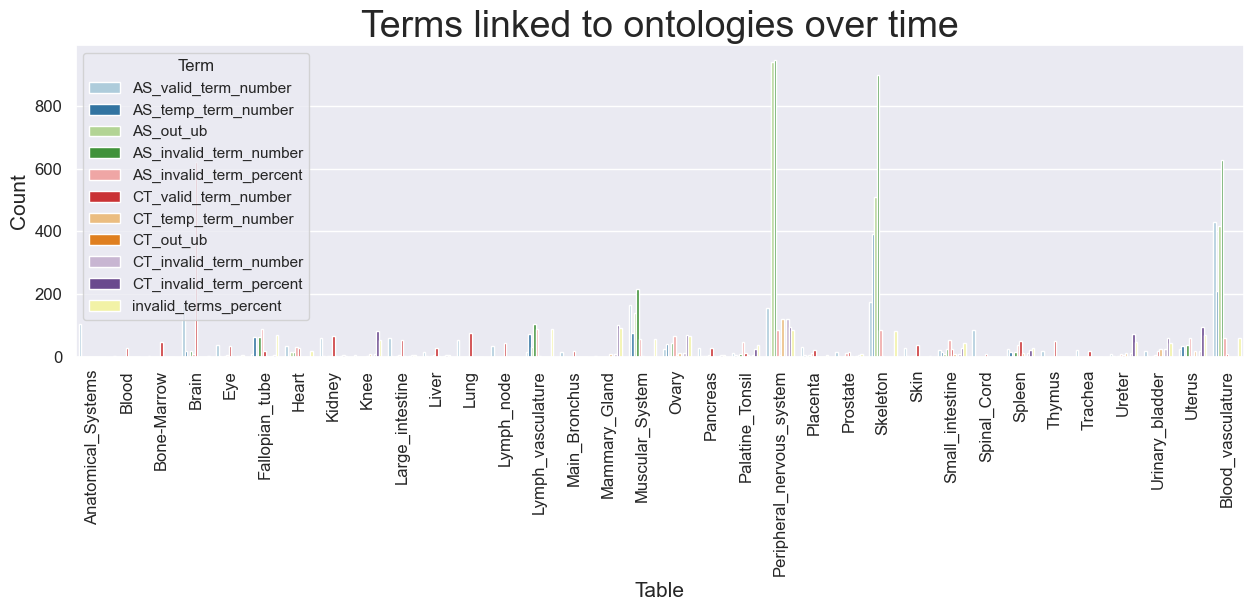

In [500]:
# no vega-lite spec available


# g = sns.FacetGrid(linked_over_time_long, col="Table", col_wrap=5)
# g.map(sns.barplot, "Term", "count", hue="Table", data=linked_over_time_long)

sns.barplot(
    data=linked_over_time_long,
    x='Table',
    y='count',
    hue='Term',
    palette="Paired"
)

# Customize the plot
plt.title('Terms linked to ontologies over time')
plt.xlabel('Table')
plt.ylabel('Count')

# Rotate x-axis labels by 90 degrees
# g.set_xticklabels(rotation=90)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()